# 24.01 Capstone: Supervised Learning

## Dataset Selection

### Dataset of Interest: Census Income Data Set 

- Repository Home: https://archive.ics.uci.edu/ml/datasets/Census+Income
- Abstract: Predict whether income exceeds $50K/yr based on census data. Also known as "Adult" dataset.

- Source: 
    - Ronny Kohavi and Barry Becker
    - Data Mining and Visualization
    - Silicon Graphics.
    - e-mail: ronnyk '@' sgi.com for questions.
    
- Data Set Variables:
    - _age_: Age of the individual in the observation.
    - _workclass_: Employment status of the individual in the observation.
    - _fnlwgt_: final weight, the number of people the census believes the entry represents. 
    - _educaiton_: Highest level of education achieved by the individual in the observation.
    - _education_num_: Equivalent grade level
    - _marital_status_: Martial status of the individual in the observation.
    - _occupation_: The occupation of the individual in the observation. 
    - _relationship_: What the individual in the observation is in relation to others.
    - _race_: Census race categories
    - _sex_: Biological sex of the individual in the observation.
    - _capital_gain_: Reported capital gains for the individual in the observation.
    - _capital_loss_: Reported capital loss for the individual in the observation.
    - _hours_per_week_: Reported work hours per week for the individual in the observation.
    - _native_country_: Country of origin for the individual
    - _income_: Identifier for income level

### Imports

In [15]:
import math

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from scipy import stats
from scipy.stats.mstats import winsorize
from scipy.stats import percentileofscore

### User Functions

In [2]:
def df_info(dataframe):
    """
    Print out some basic info about the dataframe being passed in.  Print the data types, number of rows and columns, column indexes and names, and the precent null for each column
    """
    print("Data Types:")
    print(dataframe.dtypes)
    print("="*80)
    print(f"Rows: {dataframe.shape[0]} | Columns: {dataframe.shape[1]}")
    print("="*80)
    print("Column Names: ")
    for i, col in enumerate(dataframe.columns):
        print(f"\t{i:>5} {col}")
    print("="*80)
    print("Percent Null")
    print(dataframe.apply(lambda x: sum(x.isnull()) / dataframe.shape[0]))

In [3]:
def display_iqr_info(dataframe, threshold=1.5):
    """
    Take in a dataframe and return Interquartile Range (IQR) information.  The IQR Threshold is set to 1.5 by default but can be overridden.
    """
    # Determine the first and third quartiles for each variable and return a series
    Q1 = dataframe.quantile(0.25)
    Q3 = dataframe.quantile(0.75)

    # Calculate the Interquartile Range
    IQR = Q3 - Q1

    # Get the min and max values for the columns
    col_max = dataframe.max()
    col_min = dataframe.min()

    # Get the Upper and Lower Whiskers
    lower_whisker = Q1 - threshold*IQR
    upper_whisker = Q3 + threshold*IQR

    # Create a dict for columns skewness
    col_skew = dict()
    
    # Create a dict for the outlier count
    outlier_count = dict()

    for col in dataframe.columns: 
        # Get the skewness for the column
        col_skew.update({col:dataframe[col].skew()})

        # Get the number of outliers detected
        outlier_count.update({col:dataframe[col][dataframe[col]>=threshold].shape[0]})

    # Create a series of column skew
    skewness = pd.Series(col_skew)
    
    # Create a series of outlier counts
    outliers = pd.Series(outlier_count)
    # Define the columns for the ouput dataframe
    df_cols = [col_min,col_max,lower_whisker,Q1,IQR,Q3,upper_whisker,skewness,outliers]

    # Set the column names
    col_names = {
        "index":"Variable",
        0.0:"MIN",
        1.0:"MAX",
        2.0:"Lower Whisker",
        0.25:"Q1",
        3.0:"Median",
        0.75:"Q3",
        4.0:"Upper Whisker",
        5.0:"Skewness",
        6.0:"Outliers"
    }
    
    # Bring the calculations together for presentation of the IQR information
    iqr_info = pd.concat(df_cols, axis=1).reset_index() .rename(columns=col_names)

    # Display the IQR dataframe
    display(iqr_info)

    # Remind the user of the threshold setting
    print(f"\nIQR Threshold: {threshold}")

    # Reminder of Quarile meanings
    print(f"\nFirst Quartile (Q1) = 25th Percentile | Median = 50th Percentile | Third Quartile (Q3) = 75th Percentile")

In [4]:
def display_zscore_info(dataframe_in,threshold=3):
    """
    Take in a dataframe and return Z-score information.  The Standard Deviation Threshold is set to 3 by default but can be overridden.
    """
    # Make a copy of the incoming dataframe to work with
    dataframe = dataframe_in.copy()

    # Return a Series of columns means
    x_bar = dataframe.mean()

    # Return a Series of column Standard Deviations
    stdev = dataframe.std()

    # Create a dictionary to hold column skewness
    col_skew = dict()

    # Create a dictionary to hold outlier values
    outlier_count = dict()

    # Calculate the Z-score for each observation 
    for col in dataframe.columns:
        # Add a Z-score column for the current column
        dataframe[f"{col}_zscore"] = (dataframe[col] - x_bar[col] / stdev[col])

        # Get the skew of the column
        col_skew.update({col:dataframe[col].skew()})

        # Get the number of outliers detected
        outlier_count.update({col:dataframe[col][dataframe[col]>=threshold].shape[0]})

    # Create a Series of column skewness
    skewness = pd.Series(col_skew)
    
    # Create a Series of outlier counts
    outliers = pd.Series(outlier_count)

    # Create a presentation dataframe from the result series
    zscore_info = pd.concat([x_bar,stdev,skewness,outliers],axis=1)

    # Assign column names
    zscore_info.columns = ["Mean","Std Dev","Skewness","Outliers"]

    # Display the dataframe
    display(zscore_info)

    # Remind the user what the Standard Deviation Thrshold is
    print(f"\nStandard Deviation Threshold: {threshold}")

    # Remind the user how much data is encompased at each standard deviation
    print(f"\n68-95-99.7 Rule, the percentage of values that lie within a band around the mean in a normal distribution with a width of two, four, and six standard deviations.")

In [5]:
def winsorized_comparison(df, col, tup):
    """Create a set of box plots comparing un-winsorized variables to winsorized variables.  Take in a dataframe, a column name, and a tuple pair that delinates the lower and upper cuts for winsorization."""
    plt.figure(figsize=(18,6))

    plt.subplot(1,2,1)
    plt.boxplot(df[col])
    plt.xticks([1], [col])
    plt.title(f"Box Plot of unwinsorized {col}")

    plt.subplot(1,2,2)
    winsorized = winsorize(df[col], tup)
    plt.boxplot(winsorized)
    plt.xticks([1], [f"{col} (winsorized)"])
    plt.title(f"Box Plot of winsorized {col}")

    plt.suptitle(f"Unwinsorized and Winsorized box plots of {col}")
    plt.show()

    q75, q25 = np.percentile(winsorized, [75, 25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    outliers = len((np.where((winsorized > max_val) 
                | (winsorized < min_val))[0]))

    pcnt_min = percentileofscore(winsorized, min_val)
    pcnt_max = percentileofscore(winsorized, max_val)
    
    display(f"{col} - IQR Threshold: {1.5:>{4}.1f} | Outliers: {outliers}")
    display(f"Percentile of Min: {pcnt_min} | Percentile of Max: {pcnt_max}")

In [6]:
# Plot a correlaiton matrix
def corr_plot(corr_mat,figsize):
    """
    Pass in a correlation matrix and figsize (as a tuple) and plot the resulting heatmap.
    """
    plt.figure(figsize=figsize)

    sns.heatmap(corr_mat, square=True, annot=True, linewidth=0.5)
    plt.title(f"Correlation matrix of continuous variables")

    # Fix display issues for this version of matplotlib
    b,t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b,t)
    # plt.yticks(rotation=360)

    plt.show();

### Data Loading

In [7]:
# Load the dataset, variable names must be defined as they are not included in a header row
df_raw = pd.read_csv("adult.data",sep=",", names=["age","workclass","fnlwgt","education","education_num",
    "marital_status","occupation","relationship","race","sex","capital_gain","capital_loss","hours_per_week",
    "native_country","income"],index_col=False)

In [8]:
# The imported data had leading and trailining spaces in categorical columns, strip them off
for col in df_raw.select_dtypes(include=["object","category"]).columns:
    df_raw[col] = df_raw[col].str.strip()

## Exploratory Data Analysis

### General dataset information

- How many variables?
    - 15 variables
- How many datapoints? 
    - 32,561 observations
- Which are continuous and which are categorical?
    - continuous: _age_, _fnlwgt_, _education_num_, _capital_gain_, _capital_loss_, _hours_per_week_
    - categorical: _workclass_, _education_, _marital_status_, _occupation_, _relationship_, _race_, _sex_, _native_country_, _income_
- Are the any missing data?  If so, how much?
    - There is no missing data at import.

In [9]:
# Print out basic info on the dataframe
df_info(df_raw)

Data Types:
age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object
Rows: 32561 | Columns: 15
Column Names: 
	    0 age
	    1 workclass
	    2 fnlwgt
	    3 education
	    4 education_num
	    5 marital_status
	    6 occupation
	    7 relationship
	    8 race
	    9 sex
	   10 capital_gain
	   11 capital_loss
	   12 hours_per_week
	   13 native_country
	   14 income
Percent Null
age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education_num     0.0
marital_status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital_gain      0.0
capital_loss      0.0
hours_per_week    0.

Take a look at the unique values in the variables, there may be some categorical variables masquerading as continuous variables.

In [10]:
# Create a paraent list to hold dataframe elements
parent = list()

# Looking for possible Nominal, Dichotomus, or Ordinal features.  Take a look a unique values
for col in df_raw.columns:
    # Get a count of unique values in the categorical column
    unique_count = df_raw[col].nunique()

    # Append the column name and unique count to the parent list
    parent.append([col,unique_count,df_raw[col].dtype])

# Build a dataframe to display the unique values
column_uniques = pd.DataFrame(parent,columns=["Variable","Unique_Values","Current_Datatype"])

# Display the summary dataframe
column_uniques

Variable  Unique_Values Current_Datatype
0              age             73            int64
1        workclass              9           object
2           fnlwgt          21648            int64
3        education             16           object
4    education_num             16            int64
5   marital_status              7           object
6       occupation             15           object
7     relationship              6           object
8             race              5           object
9              sex              2           object
10    capital_gain            119            int64
11    capital_loss             92            int64
12  hours_per_week             94            int64
13  native_country             42           object
14          income              2           object

### Continuous Variable Distributions
What are the probability distributions of the continuous variables

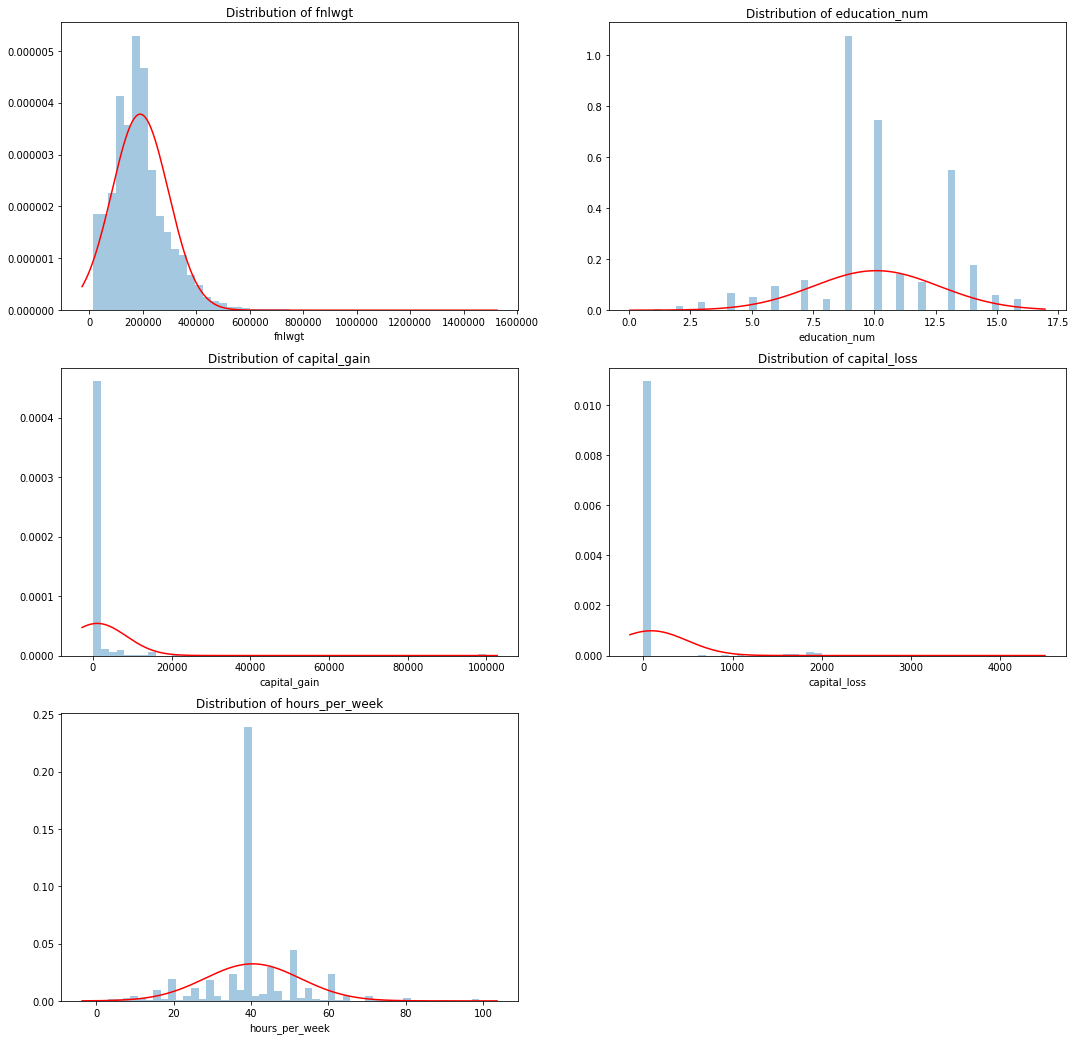

In [11]:
# Take a look at select condinuous columns, exclude age as it will be binned
plt_df = df_raw.select_dtypes(exclude=["object","category"]).iloc[:,1:]

# Number of presentation columns
cols = 2

# Number of presentation rows
rows = math.ceil(len(plt_df.columns)/2)

# Set the figure size
plt.figure(figsize=(18,(rows*6)))

# Loop over the continuous columns
for i, col in enumerate(plt_df.columns, start=1): 
    # Create a subplot
    plt.subplot(rows,cols,i)
    # Draw a seaborn distribution plot with a fitted normal curve
    sns.distplot(plt_df[col], fit=stats.norm, kde=False, fit_kws=dict(color="r"))
    # Set the plot title with the column name
    plt.title(f"Distribution of {col}")

# display the plot
plt.show();

### Dealing with outliers

Take a look at the outliers in the continuous variables

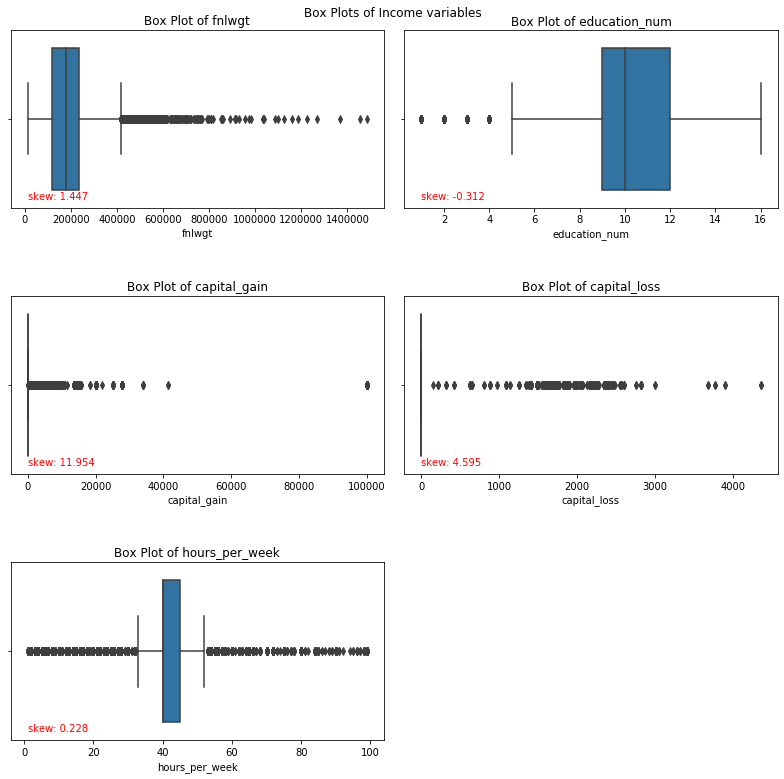

In [12]:
# Take an initial look at the outliers using IQR and box plots
plt.figure(figsize=(11,11))

for i, col in enumerate(plt_df.columns): 
    plt.subplot(3,2,(i+1))
    sns.boxplot(data=plt_df, x=plt_df[col])
    plt_skew = plt_df[col].skew()
    plt.text(x=np.min(plt_df[col]), y=0.45, s=f"skew: {plt_skew:0.3f}", color="r")
    plt.title(f"Box Plot of {col}")


plt.suptitle("Box Plots of Income variables")
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, top=0.95)

plt.show();

In [13]:
# Show the Innerquartile Range (IQR) info and get outliers
display_iqr_info(plt_df)

Variable    MIN      MAX  Lower Whisker        Q1    Median  \
0          fnlwgt  12285  1484705       -61009.0  117827.0  119224.0   
1   education_num      1       16            4.5       9.0       3.0   
2    capital_gain      0    99999            0.0       0.0       0.0   
3    capital_loss      0     4356            0.0       0.0       0.0   
4  hours_per_week      1       99           32.5      40.0       5.0   

         Q3  Upper Whisker   Skewness  Outliers  
0  237051.0       415887.0   1.446980     32561  
1      12.0           16.5  -0.311676     32510  
2       0.0            0.0  11.953848      2712  
3       0.0            0.0   4.594629      1519  
4      45.0           52.5   0.227643     32541


IQR Threshold: 1.5

First Quartile (Q1) = 25th Percentile | Median = 50th Percentile | Third Quartile (Q3) = 75th Percentile


In [14]:
# Compare IQR outlier detection to Z-score outlier detection
display_zscore_info(plt_df)

Mean        Std Dev   Skewness  Outliers
fnlwgt          189778.366512  105549.977697   1.446980     32561
education_num       10.080679       2.572720  -0.311676     32342
capital_gain      1077.648844    7385.292085  11.953848      2712
capital_loss        87.303830     402.960219   4.594629      1519
hours_per_week      40.437456      12.347429   0.227643     32509


Standard Deviation Threshold: 3

68-95-99.7 Rule, the percentage of values that lie within a band around the mean in a normal distribution with a width of two, four, and six standard deviations.


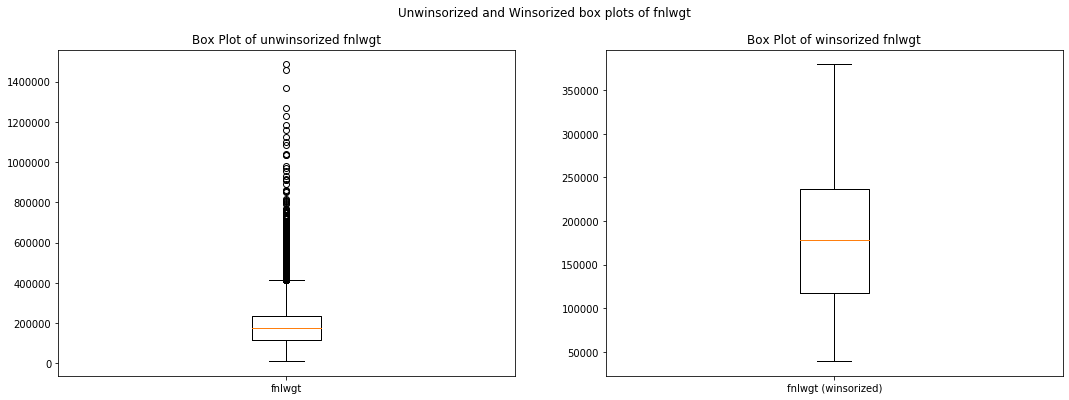

'fnlwgt - IQR Threshold:  1.5 | Outliers: 0'

'Percentile of Min: 0.0 | Percentile of Max: 100.0'

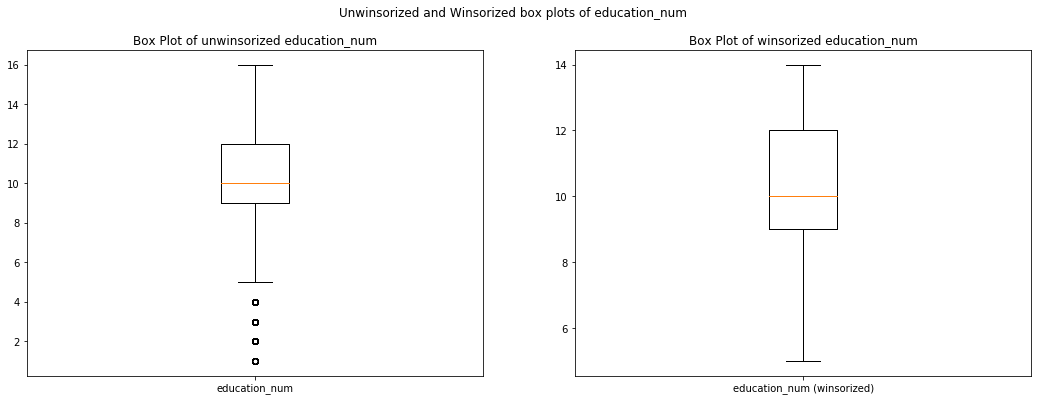

'education_num - IQR Threshold:  1.5 | Outliers: 0'

'Percentile of Min: 0.0 | Percentile of Max: 100.0'

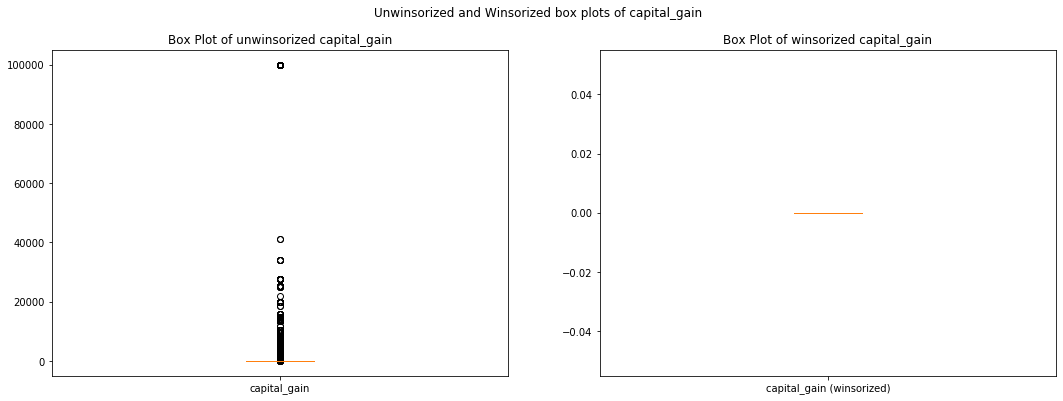

'capital_gain - IQR Threshold:  1.5 | Outliers: 0'

'Percentile of Min: 50.0015355793741 | Percentile of Max: 50.0015355793741'

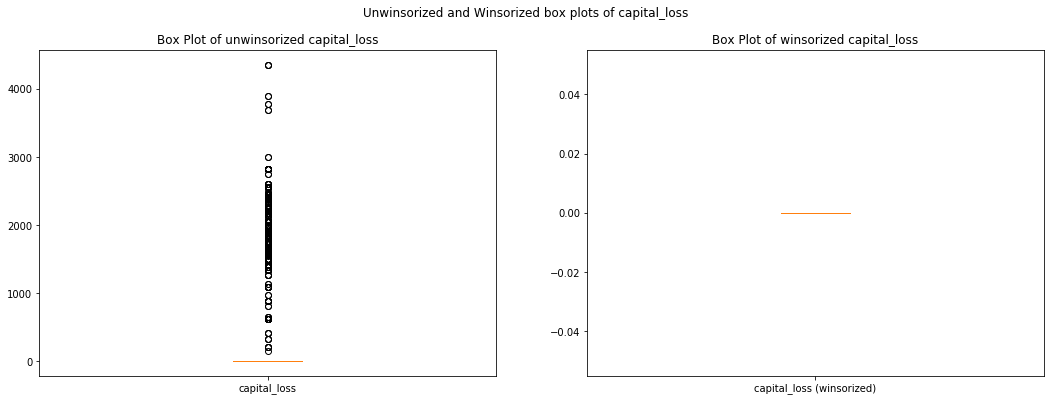

'capital_loss - IQR Threshold:  1.5 | Outliers: 0'

'Percentile of Min: 50.0015355793741 | Percentile of Max: 50.0015355793741'

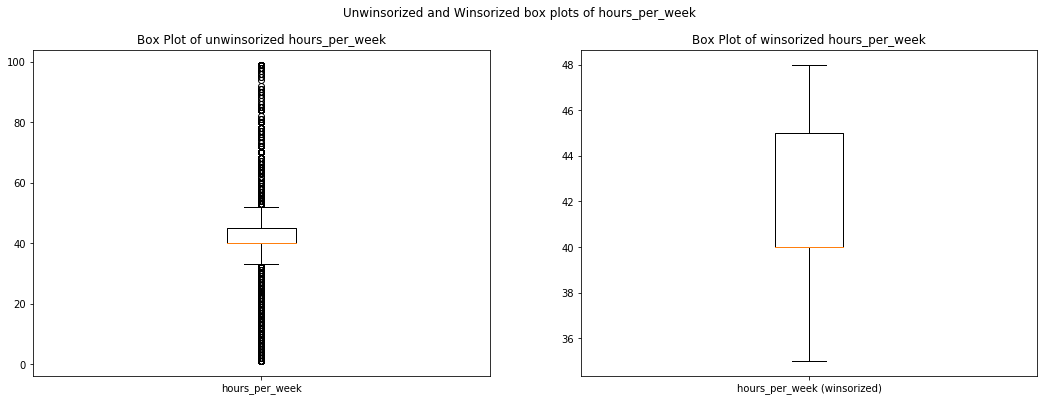

'hours_per_week - IQR Threshold:  1.5 | Outliers: 0'

'Percentile of Min: 0.0 | Percentile of Max: 100.0'

In [16]:
# Create a dict to store columns and winsorization cutoff values
winsorize_vals = dict(
    fnlwgt=(0.05,0.05),
    education_num=(0.05,0.05),
    capital_gain=(0.10,0.10),
    capital_loss=(0.05,0.05),
    hours_per_week=(0.20,0.20)
)

# Plot the winsorized values for comparison sake and see if your missing any outliers 
for i, (k,v) in enumerate(winsorize_vals.items()):
    # print(f"index: {i}, key: {k}, value: {v}")
    winsorized_comparison(plt_df,k,v)

In [29]:
# Now that the outliers have been identified, join winsorized columns to the dataframe
df_winsorized = df_raw.copy()

for i, (k,v) in enumerate(winsorize_vals.items()):
    df_winsorized[f"{k}_winsorized"] = winsorize(df_winsorized[k], v)

In [30]:
# Describe while suppressing scientific notation
pd.set_option("display.float_format", lambda x: f"{x:.5f}")
# capture the describe function data for possible later use
continuous_described = df_winsorized.describe()
# Show the central tendency information
display(continuous_described)
# Reset Pandas display back to normal
pd.reset_option("display.float_format")

age        fnlwgt  education_num  capital_gain  capital_loss  \
count 32561.00000   32561.00000    32561.00000   32561.00000   32561.00000   
mean     38.58165  189778.36651       10.08068    1077.64884      87.30383   
std      13.64043  105549.97770        2.57272    7385.29208     402.96022   
min      17.00000   12285.00000        1.00000       0.00000       0.00000   
25%      28.00000  117827.00000        9.00000       0.00000       0.00000   
50%      37.00000  178356.00000       10.00000       0.00000       0.00000   
75%      48.00000  237051.00000       12.00000       0.00000       0.00000   
max      90.00000 1484705.00000       16.00000   99999.00000    4356.00000   

       hours_per_week  fnlwgt_winsorized  education_num_winsorized  \
count     32561.00000        32561.00000               32561.00000   
mean         40.43746       185788.94404                  10.09966   
std          12.34743        91228.73006                   2.33451   
min           1.00000        39460.00000                   5.00000   
25%          40.00000       117827.00000                   9.00000   
50%          40.00000       178356.00000                  10.00000   
75%          45.00000       237051.00000                  12.00000   
max          99.00000       379682.00000                  14.00000   

       capital_gain_winsorized  capital_loss_winsorized  \
count              32561.00000              32561.00000   
mean                   0.00000                  0.00000   
std                    0.00000                  0.00000   
min                    0.00000                  0.00000   
25%                    0.00000                  0.00000   
50%                    0.00000                  0.00000   
75%                    0.00000                  0.00000   
max                    0.00000                  0.00000   

       hours_per_week_winsorized  
count                32561.00000  
mean                    40.95442  
std                      4.48267  
min                     35.00000  
25%                     40.00000  
50%                     40.00000  
75%                     45.00000  
max                     48.00000

In [31]:
# Describe while suppressing scientific notation
pd.set_option("display.float_format", lambda x: f"{x:.5f}")
# Capture the describe function data for possible later use
categorical_described = df_winsorized.describe(include="O")
# Show the central tendency information
display(categorical_described)
# Reset Pandas display back to normal
pd.reset_option("display.float_format")

workclass education      marital_status      occupation relationship  \
count      32561     32561               32561           32561        32561   
unique         9        16                   7              15            6   
top      Private   HS-grad  Married-civ-spouse  Prof-specialty      Husband   
freq       22696     10501               14976            4140        13193   

         race    sex native_country income  
count   32561  32561          32561  32561  
unique      5      2             42      2  
top     White   Male  United-States  <=50K  
freq    27816  21790          29170  24720

Winsorization is a bit of a mixed bag with this dataset.  _(F)nlwgt_ that I believe would benefit from a transformation as opposed to a reduction in variance.  _(E)ducation_num_ is going to be dropped outright as the _education_ variable is it's equivealent.  _(C)apital_gain/loss were not helped at all by winsorization.  These two values will be consolidated into a new categorical variable.  _(H)ours_per_week did seem to benefit from winsorization which I will retain moving into model preparation.

fnlwgt  hours_per_week_winsorized
fnlwgt                     1.000000                  -0.022543
hours_per_week_winsorized -0.022543                   1.000000

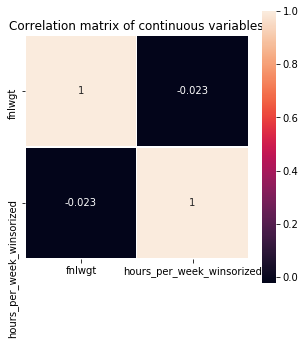

In [32]:
# Take a look at the correlations between continuous variables, that will be retained 
continuous_corr = df_winsorized[["fnlwgt","hours_per_week_winsorized"]].corr()

# Display the correlation table
display(continuous_corr)

# Get a column count to set the figure size 
col_count = len(plt_df.columns)

# Plot the correlation matrix
corr_plot(continuous_corr,(col_count,col_count))

As you can seek in the heatmap the two remaining continuous variables, _fnlwgt_ and _hours_per_week_ have correlation coefficients approaching zero.

To visualize the categorical variables I'll break up the visualizations.  First I'll loop over the continuous variables with low unique values to produce the bar charts.  Then I'll generate the high unique charts individually.

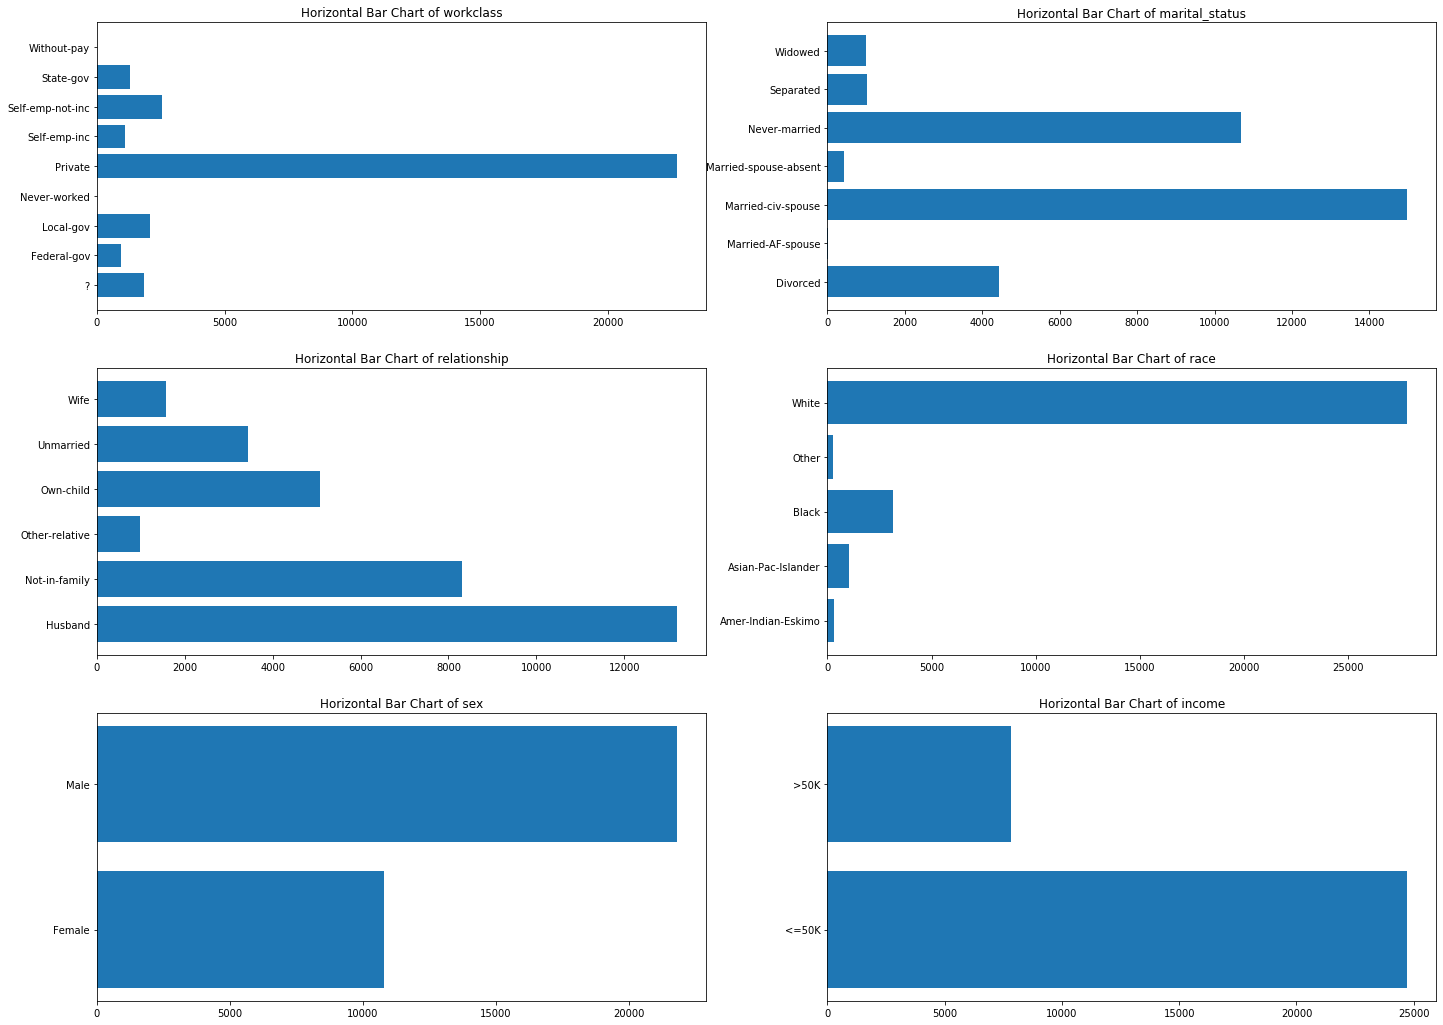

In [21]:
# Select to variables to loop over
small_uniques = ["workclass","marital_status","relationship","race","sex","income"]

# Set the presentation columns
cols = 2

# Set the presentation Rows
rows = math.ceil(len(small_uniques)/2)

# Set the figure size
plt.figure(figsize=(24,(rows*6)))

# Loop over the variables with low unique value counts
for i, col in enumerate(df_raw[small_uniques].columns, start=1):
    plt.subplot(rows, cols, i)
    # Generate the bar chart for the variable
    plt.barh(df_raw.groupby(f"{col}")[f"{col}"].count().index,
        df_raw.groupby(f"{col}")[f"{col}"].count())
    # Set the subplot title to the variable 
    plt.title(f"Horizontal Bar Chart of {col}")

# Display the figure
plt.show();

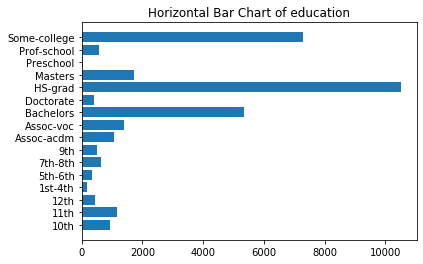

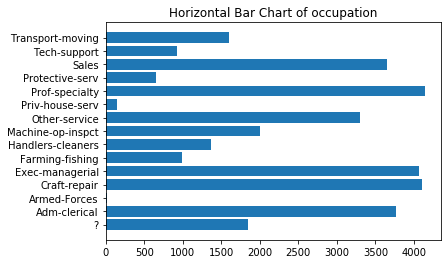

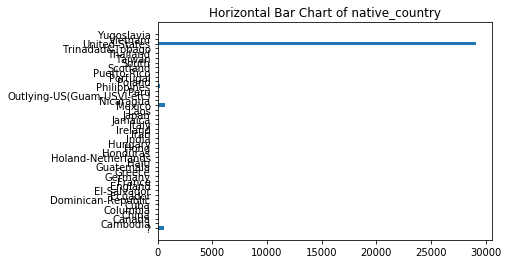

In [22]:
# Select to variables to loop over
large_uniques = ["education","occupation","native_country"]

# Loop over the variables with low unique value counts
for i, col in enumerate(df_raw[large_uniques].columns, start=1):
    # Generate the barchart for the variable
    plt.barh(df_raw.groupby(f"{col}")[f"{col}"].count().index,
        df_raw.groupby(f"{col}")[f"{col}"].count())
    # Set the plot title to the variable
    plt.title(f"Horizontal Bar Chart of {col}")

    # Display the figure
    plt.show();

As illustrateed above several of the categorical variable have a high degree of class imbalance which will be dealt with later. Right now I want to take a look at the relationships between the continuous variables.  I'll take a look at a correlation matrix first to see if there is any value in producing scatter plots.